# Complete historical emissions

This script makes a file of historical emissions from 1750-2024 that is suitable for harmonization to future scenarios.

The input data is from IIASA's emissions harmonization historical at https://github.com/iiasa/emissions_harmonization_historical 

Do we want two versions?
1. historical including biomass burning variability to 2024
2. harmonization for future scenarios, by smoothing out the biomass burning by using e.g. a 5- or 10-year smoothing filter.

The starting point is the historical emissions from CMIP7 ScenarioMIP: we want these to be exactly consistent with the ScenarioMIP final emissions from 1990 to 2021 for all species. This is the period which harmonization will occur. Where datasets are complete and final, extend before 1990 or after 2021, and present in ScenarioMIP, we will also use these. Where this is not the case, we will make some justifyable assumptions/extrapolations/extensions that ScenarioMIP would consider too fruity, but are Good Enough For Government Work.

The historical emissions will be used to produce v1.5.0 of the fair calibration.

This will use several data sources; we will try to clearly label them!

In [1]:
import warnings
import os

import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
from scipy.stats import linregress
from scipy.interpolate import CubicSpline

In [2]:
# the ScenarioMIP state of play
df_scenariomip = pd.read_csv('../data/input/cmip7_history_world_0022.csv')

In [3]:
df_scenariomip

,model,scenario,variable,region,unit,1750,1751,1752,1753,1754,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,"Adam et al., 2024",historical,Emissions|HFC|HFC23,World,kt HFC23/yr,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|BC,World,Mt BC/yr,2.120093,2.095695,2.087551,2.095685,2.123610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|CH4,World,Mt CH4/yr,40.669223,40.535916,40.480450,40.680802,41.035811,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|CO,World,Mt CO/yr,348.838265,344.229341,342.107935,343.976352,350.125174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|N2O,World,kt N2O/yr,908.671278,898.444758,894.551932,899.436738,919.329087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|NH3,World,Mt NH3/yr,6.752106,6.683606,6.642037,6.703241,6.836352,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|NOx,World,Mt NO2/yr,19.443706,19.223945,19.226670,19.142753,19.291447,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|OC,World,Mt OC/yr,16.020452,15.762729,15.609871,15.759779,16.138189,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|Sulfur,World,Mt SO2/yr,2.350436,2.316251,2.303261,2.315421,2.365301,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|VOC,World,Mt VOC/yr,60.931603,59.999242,59.545198,59.942928,61.191229,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# we can crib this to make our actual emissions dataset
df_emissions = df_scenariomip.copy()

In [5]:
# firstly, we don't want to extrapolate past 2024
df_emissions = df_emissions.loc[:, :'2024']
df_emissions

,model,scenario,variable,region,unit,1750,1751,1752,1753,1754,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,"Adam et al., 2024",historical,Emissions|HFC|HFC23,World,kt HFC23/yr,NaN,NaN,NaN,NaN,NaN,...,12.873911,12.786738,15.123099,16.832850,17.311925,16.505140,15.533804,13.954472,14.051843,NaN
1,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|BC,World,Mt BC/yr,2.120093,2.095695,2.087551,2.095685,2.123610,...,7.629747,7.230268,7.292787,7.092049,7.394743,6.970417,7.339760,6.699266,7.557077,NaN
2,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|CH4,World,Mt CH4/yr,40.669223,40.535916,40.480450,40.680802,41.035811,...,354.122762,345.692180,348.736373,351.901783,358.850123,345.322687,355.843503,354.909306,369.092729,NaN
3,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|CO,World,Mt CO/yr,348.838265,344.229341,342.107935,343.976352,350.125174,...,891.630067,753.791984,746.266581,741.428971,816.666647,727.501488,786.430347,665.832281,896.703380,NaN
4,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|N2O,World,kt N2O/yr,908.671278,898.444758,894.551932,899.436738,919.329087,...,10670.047291,10559.820344,10773.385377,10846.542426,11037.534163,10902.966166,11362.418657,10877.249387,11611.055194,NaN
5,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|NH3,World,Mt NH3/yr,6.752106,6.683606,6.642037,6.703241,6.836352,...,63.891314,63.552641,63.988451,64.625449,66.287414,66.225354,68.252751,66.823590,71.567399,NaN
6,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|NOx,World,Mt NO2/yr,19.443706,19.223945,19.226670,19.142753,19.291447,...,139.745042,136.048305,135.812328,133.308471,134.102561,122.513800,125.887804,123.285151,128.443392,NaN
7,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|OC,World,Mt OC/yr,16.020452,15.762729,15.609871,15.759779,16.138189,...,32.017727,27.332945,29.075610,28.119274,34.028717,29.431480,36.815407,25.604698,41.091117,NaN
8,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|Sulfur,World,Mt SO2/yr,2.350436,2.316251,2.303261,2.315421,2.365301,...,92.294374,88.378784,84.873139,82.555913,81.107588,68.356225,71.178790,70.578348,72.655510,NaN
9,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|VOC,World,Mt VOC/yr,60.931603,59.999242,59.545198,59.942928,61.191229,...,213.228990,185.865550,187.062081,186.552979,205.886462,185.547869,200.706796,176.461165,219.644313,NaN


In [6]:
# secondly, CO2 and N2O are in silly* units, so let's fix
df_emissions.loc[df_emissions['variable']=='Emissions|N2O', '1750':] = df_emissions.loc[df_emissions['variable']=='Emissions|N2O', '1750':] / 1000
df_emissions.loc[df_emissions['variable']=='Emissions|CO2|Energy and Industrial Processes', '1750':] = (
    df_emissions.loc[df_emissions['variable']=='Emissions|CO2|Energy and Industrial Processes', '1750':] / 1000
)
# we haven't gone before 1850 yet for CO2 AFOLU
df_emissions.loc[df_emissions['variable']=='Emissions|CO2|AFOLU', '1850':] = (
    df_emissions.loc[df_emissions['variable']=='Emissions|CO2|AFOLU', '1850':] / 1000
)

df_emissions.loc[df_emissions['variable']=='Emissions|N2O', 'unit'] = 'Mt N2O/yr'
df_emissions.loc[df_emissions['variable']=='Emissions|CO2|Energy and Industrial Processes', 'unit'] = 'Gt CO2/yr'
df_emissions.loc[df_emissions['variable']=='Emissions|CO2|AFOLU', 'unit'] = 'Gt CO2/yr'
df_emissions
# *ok, I can see an argument for CO2 in Mt, but N2O in kt is batshit.

,model,scenario,variable,region,unit,1750,1751,1752,1753,1754,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,"Adam et al., 2024",historical,Emissions|HFC|HFC23,World,kt HFC23/yr,NaN,NaN,NaN,NaN,NaN,...,12.873911,12.786738,15.123099,16.832850,17.311925,16.505140,15.533804,13.954472,14.051843,NaN
1,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|BC,World,Mt BC/yr,2.120093,2.095695,2.087551,2.095685,2.123610,...,7.629747,7.230268,7.292787,7.092049,7.394743,6.970417,7.339760,6.699266,7.557077,NaN
2,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|CH4,World,Mt CH4/yr,40.669223,40.535916,40.480450,40.680802,41.035811,...,354.122762,345.692180,348.736373,351.901783,358.850123,345.322687,355.843503,354.909306,369.092729,NaN
3,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|CO,World,Mt CO/yr,348.838265,344.229341,342.107935,343.976352,350.125174,...,891.630067,753.791984,746.266581,741.428971,816.666647,727.501488,786.430347,665.832281,896.703380,NaN
4,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|N2O,World,Mt N2O/yr,0.908671,0.898445,0.894552,0.899437,0.919329,...,10.670047,10.559820,10.773385,10.846542,11.037534,10.902966,11.362419,10.877249,11.611055,NaN
5,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|NH3,World,Mt NH3/yr,6.752106,6.683606,6.642037,6.703241,6.836352,...,63.891314,63.552641,63.988451,64.625449,66.287414,66.225354,68.252751,66.823590,71.567399,NaN
6,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|NOx,World,Mt NO2/yr,19.443706,19.223945,19.226670,19.142753,19.291447,...,139.745042,136.048305,135.812328,133.308471,134.102561,122.513800,125.887804,123.285151,128.443392,NaN
7,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|OC,World,Mt OC/yr,16.020452,15.762729,15.609871,15.759779,16.138189,...,32.017727,27.332945,29.075610,28.119274,34.028717,29.431480,36.815407,25.604698,41.091117,NaN
8,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|Sulfur,World,Mt SO2/yr,2.350436,2.316251,2.303261,2.315421,2.365301,...,92.294374,88.378784,84.873139,82.555913,81.107588,68.356225,71.178790,70.578348,72.655510,NaN
9,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|VOC,World,Mt VOC/yr,60.931603,59.999242,59.545198,59.942928,61.191229,...,213.228990,185.865550,187.062081,186.552979,205.886462,185.547869,200.706796,176.461165,219.644313,NaN


In [7]:
# thirdly, Halon-1202 isn't included in any CMIP6 scenarios, and its historical emissions were tiny and are now pretty much zero
# so let's remove it
df_emissions.drop(df_emissions.loc[df_emissions['variable']=='Emissions|Montreal Gases|Halon1202'].index, inplace=True)
df_emissions

,model,scenario,variable,region,unit,1750,1751,1752,1753,1754,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,"Adam et al., 2024",historical,Emissions|HFC|HFC23,World,kt HFC23/yr,NaN,NaN,NaN,NaN,NaN,...,12.873911,12.786738,15.123099,16.832850,17.311925,16.505140,15.533804,13.954472,14.051843,NaN
1,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|BC,World,Mt BC/yr,2.120093,2.095695,2.087551,2.095685,2.123610,...,7.629747,7.230268,7.292787,7.092049,7.394743,6.970417,7.339760,6.699266,7.557077,NaN
2,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|CH4,World,Mt CH4/yr,40.669223,40.535916,40.480450,40.680802,41.035811,...,354.122762,345.692180,348.736373,351.901783,358.850123,345.322687,355.843503,354.909306,369.092729,NaN
3,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|CO,World,Mt CO/yr,348.838265,344.229341,342.107935,343.976352,350.125174,...,891.630067,753.791984,746.266581,741.428971,816.666647,727.501488,786.430347,665.832281,896.703380,NaN
4,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|N2O,World,Mt N2O/yr,0.908671,0.898445,0.894552,0.899437,0.919329,...,10.670047,10.559820,10.773385,10.846542,11.037534,10.902966,11.362419,10.877249,11.611055,NaN
5,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|NH3,World,Mt NH3/yr,6.752106,6.683606,6.642037,6.703241,6.836352,...,63.891314,63.552641,63.988451,64.625449,66.287414,66.225354,68.252751,66.823590,71.567399,NaN
6,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|NOx,World,Mt NO2/yr,19.443706,19.223945,19.226670,19.142753,19.291447,...,139.745042,136.048305,135.812328,133.308471,134.102561,122.513800,125.887804,123.285151,128.443392,NaN
7,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|OC,World,Mt OC/yr,16.020452,15.762729,15.609871,15.759779,16.138189,...,32.017727,27.332945,29.075610,28.119274,34.028717,29.431480,36.815407,25.604698,41.091117,NaN
8,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|Sulfur,World,Mt SO2/yr,2.350436,2.316251,2.303261,2.315421,2.365301,...,92.294374,88.378784,84.873139,82.555913,81.107588,68.356225,71.178790,70.578348,72.655510,NaN
9,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|VOC,World,Mt VOC/yr,60.931603,59.999242,59.545198,59.942928,61.191229,...,213.228990,185.865550,187.062081,186.552979,205.886462,185.547869,200.706796,176.461165,219.644313,NaN


In [8]:
# Find all the species that don't have a 1750 value; these need backfilling
first_valid_year = {}
for variable in df_emissions.variable:
    fvy = df_emissions.loc[df_emissions['variable']==variable, '1750':].squeeze(axis=0).first_valid_index()
    if fvy != '1750':  # ignore complete variables
        first_valid_year[variable] = fvy

In [9]:
first_valid_year

{'Emissions|HFC|HFC23': '1975',
 'Emissions|CO2|AFOLU': '1850',
 'Emissions|HFC|HFC125': '1990',
 'Emissions|HFC|HFC134a': '1990',
 'Emissions|HFC|HFC143a': '1990',
 'Emissions|HFC|HFC152a': '1990',
 'Emissions|HFC|HFC227ea': '1990',
 'Emissions|HFC|HFC236fa': '1990',
 'Emissions|HFC|HFC245fa': '1990',
 'Emissions|HFC|HFC32': '1990',
 'Emissions|HFC|HFC365mfc': '1990',
 'Emissions|HFC|HFC43-10': '1990',
 'Emissions|Montreal Gases|CCl4': '1955',
 'Emissions|Montreal Gases|CFC|CFC11': '1955',
 'Emissions|Montreal Gases|CFC|CFC113': '1955',
 'Emissions|Montreal Gases|CFC|CFC114': '1955',
 'Emissions|Montreal Gases|CFC|CFC115': '1955',
 'Emissions|Montreal Gases|CFC|CFC12': '1955',
 'Emissions|Montreal Gases|CH3CCl3': '1955',
 'Emissions|Montreal Gases|HCFC141b': '1955',
 'Emissions|Montreal Gases|HCFC142b': '1955',
 'Emissions|Montreal Gases|HCFC22': '1955',
 'Emissions|Montreal Gases|Halon1211': '1955',
 'Emissions|Montreal Gases|Halon1301': '1955',
 'Emissions|Montreal Gases|Halon2402':

In [10]:
# so, everything other than CO2 AFOLU can be filled in with inversions
df_inverse = pd.read_csv('../data/input/inverse_emissions_0012.csv')

In [11]:
len(first_valid_year) - 1

27

In [12]:
df_inverse

,model,scenario,region,variable,unit,1750,1751,1752,1753,1754,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,CR-CMIP-1-0-0-inverse-smooth,historical,World,Emissions|C2F6,kt C2F6/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.995041,2.032355,2.093771,2.186288,2.311749,2.474555,2.672936,2.913770,3.194464,3.513403
1,CR-CMIP-1-0-0-inverse-smooth,historical,World,Emissions|C3F8,kt C3F8/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.561463,0.551385,0.548730,0.553962,0.566023,0.584624,0.607416,0.633849,0.662959,0.694957
2,CR-CMIP-1-0-0-inverse-smooth,historical,World,Emissions|C4F10,kt C4F10/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.092329,0.092375,0.092847,0.093610,0.094542,0.095594,0.096712,0.097898,0.099127,0.100408
3,CR-CMIP-1-0-0-inverse-smooth,historical,World,Emissions|C5F12,kt C5F12/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.054984,0.054743,0.054986,0.055538,0.056267,0.057086,0.057940,0.058802,0.059662,0.060522
4,CR-CMIP-1-0-0-inverse-smooth,historical,World,Emissions|C6F14,kt C6F14/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.156410,0.149077,0.143315,0.137618,0.131698,0.124207,0.115137,0.103555,0.090036,0.074440
5,CR-CMIP-1-0-0-inverse-smooth,historical,World,Emissions|C7F16,kt C7F16/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.191999,0.191957,0.191856,0.191635,0.191309,0.190816,0.190179,0.189353,0.188386,0.187276
6,CR-CMIP-1-0-0-inverse-smooth,historical,World,Emissions|C8F18,kt C8F18/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.083241,0.083429,0.085512,0.089157,0.093889,0.099631,0.106069,0.113297,0.121077,0.129440
7,CR-CMIP-1-0-0-inverse-smooth,historical,World,Emissions|CF4,kt CF4/yr,0.010653,0.010653,0.010653,0.010653,0.010653,...,11.578896,11.969625,12.418271,12.947338,13.556966,14.271979,15.105479,16.079442,17.179348,18.357888
8,CR-CMIP-1-0-0-inverse-smooth,historical,World,Emissions|HFC|HFC125,kt HFC125/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,51.988395,58.045868,64.439409,71.142424,78.117954,85.325800,92.737049,100.315052,107.994714,115.716406
9,CR-CMIP-1-0-0-inverse-smooth,historical,World,Emissions|HFC|HFC134a,kt HFC134a/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,191.623850,202.009562,212.940406,224.384205,236.301716,248.680380,261.506706,274.670853,287.951823,301.247904


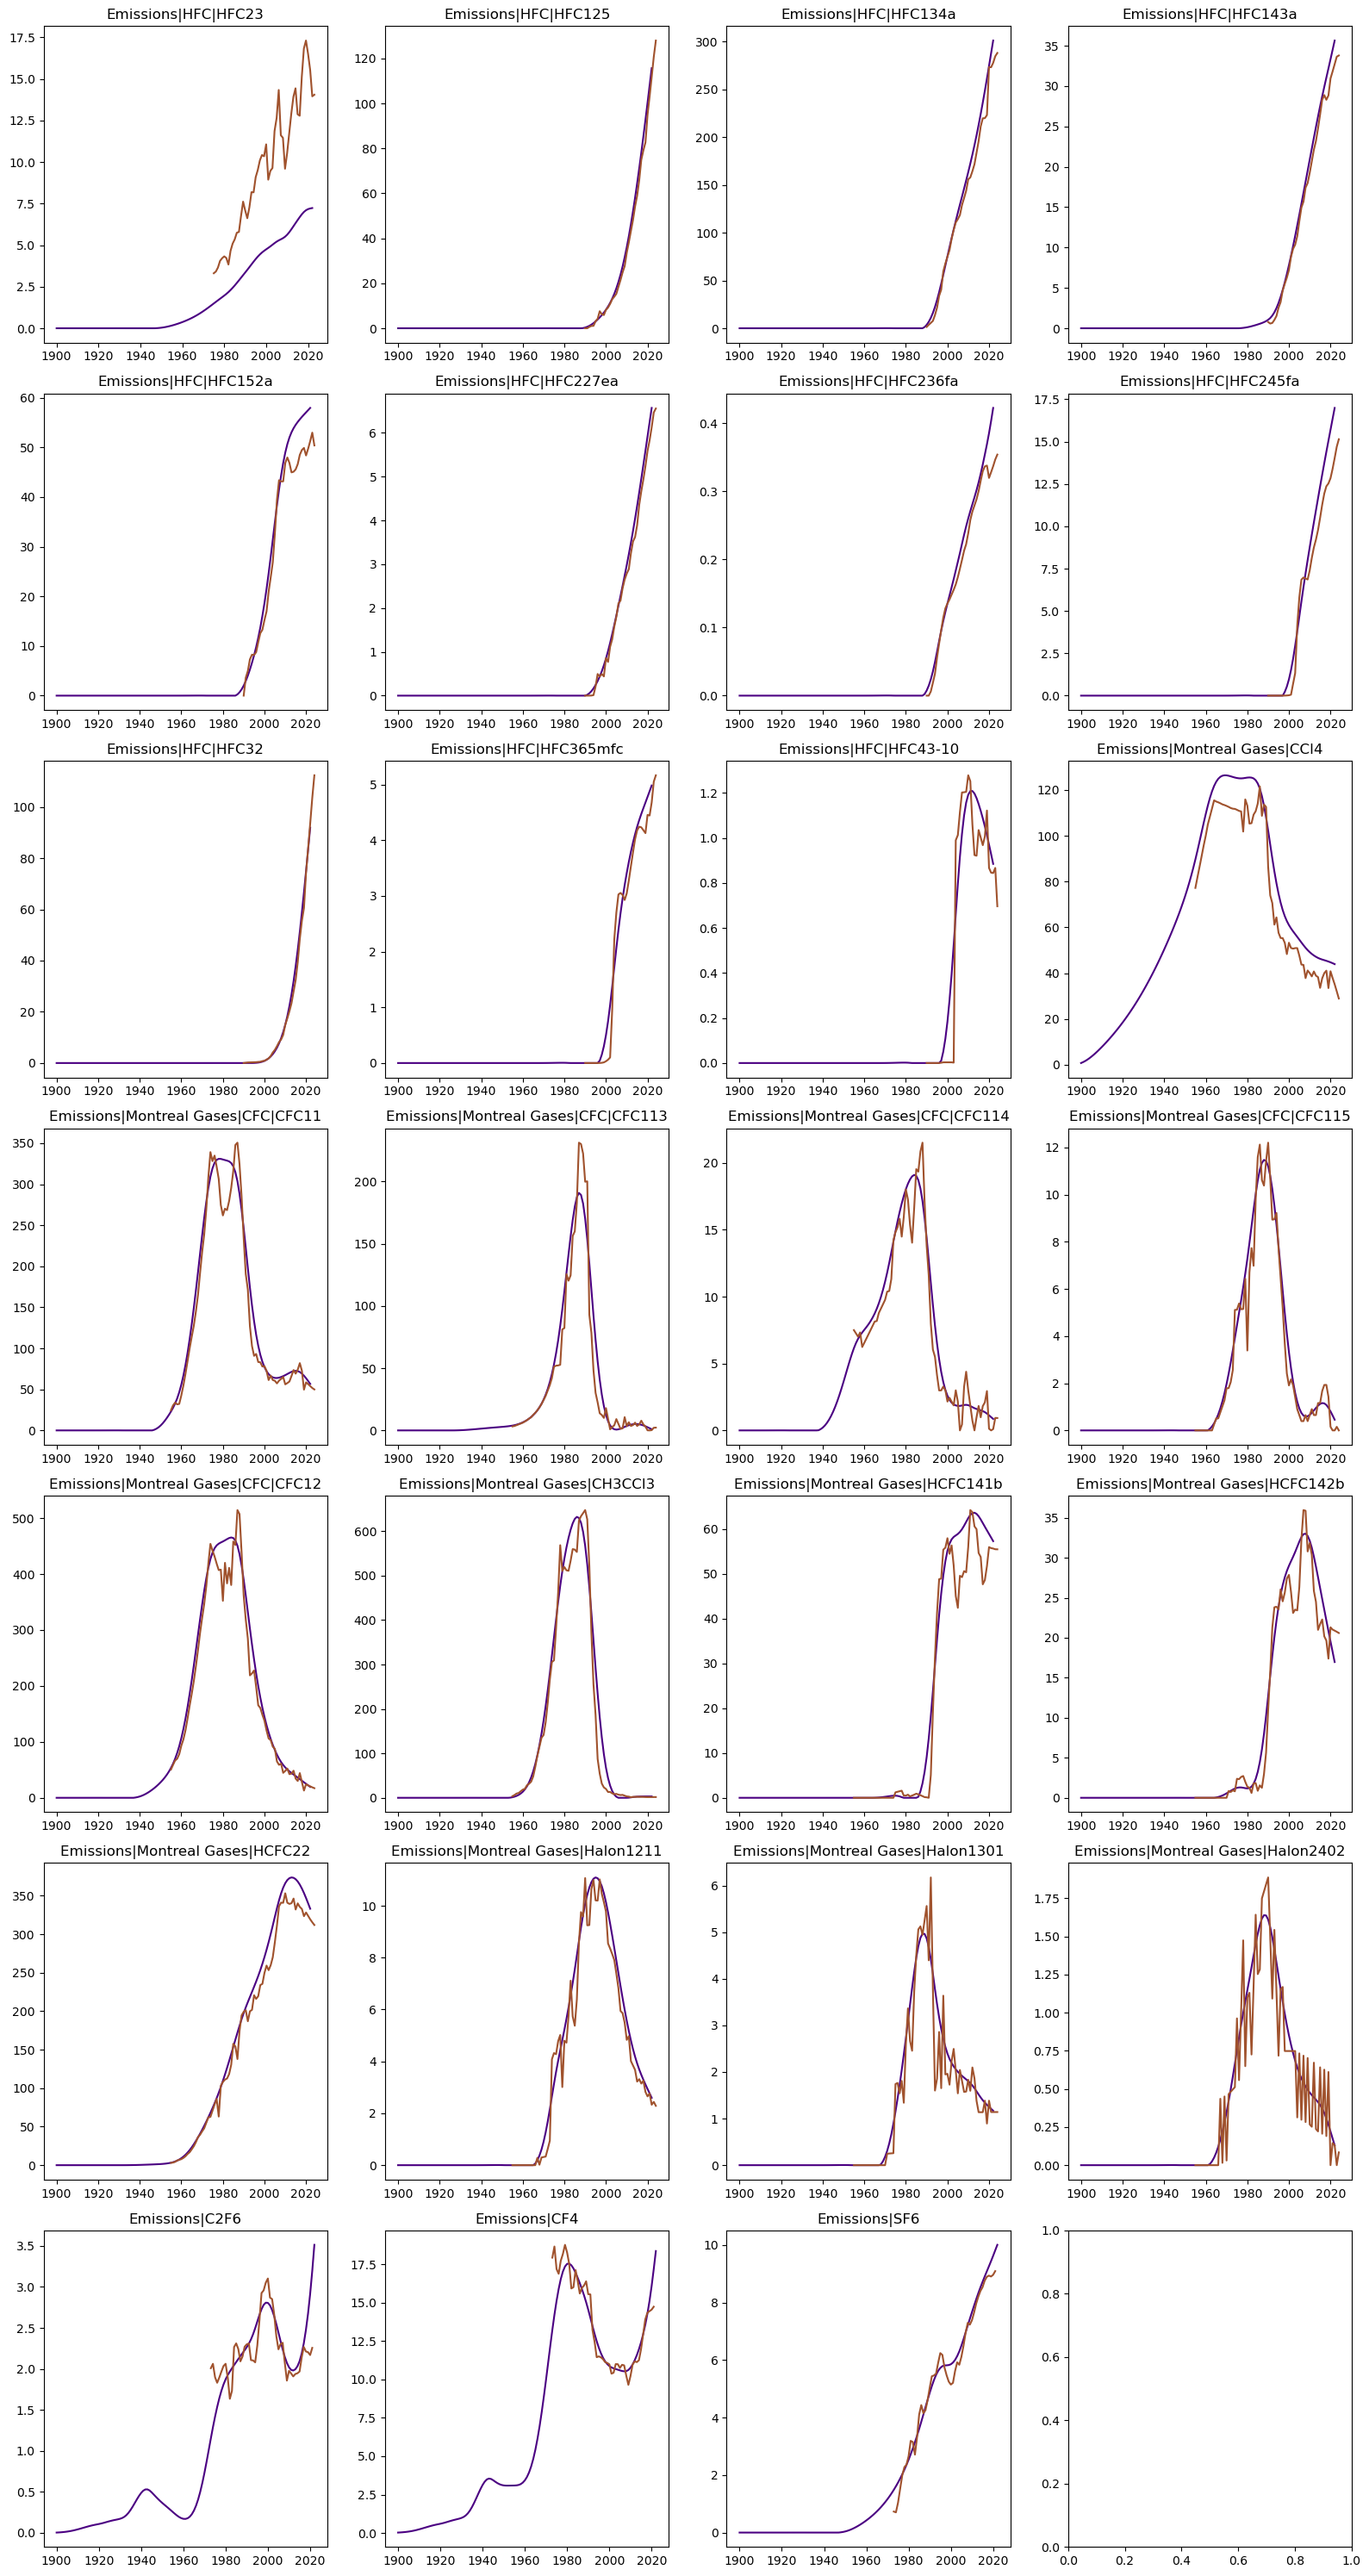

In [13]:
# let's check that the emissions look ok
fig, ax = pl.subplots(7, 4, figsize = (16, 30))
ivar = 0
for variable in first_valid_year:
    if variable != 'Emissions|CO2|AFOLU':
        ax[ivar//4, ivar%4].plot(
            np.arange(1900, 2023), 
            df_inverse.loc[df_inverse['variable']==variable, '1900':].T,
            label='inverse',
            color='indigo',
        )
        ax[ivar//4, ivar%4].plot(
            np.arange(int(first_valid_year[variable]), 2025), 
            df_emissions.loc[df_emissions['variable']==variable, first_valid_year[variable]:].T,
            color='sienna',
            label='ScenarioMIP'
        )
        ax[ivar//4, ivar%4].set_title(variable)
        ivar = ivar + 1
fig.tight_layout()

Joining logic:

- HFC23: join with scale factor
- HFC125: join
- HFC134a: join
- HFC143a: join
- HFC152a: join
- HFC227ea: join
- HFC236fa: join
- HFC245fa: join
- HFC32: join
- HFC365mfc: join
- HFC43-10: join
- CCl4: join with scale factor
- CFC11: join
- CFC113: join
- CFC114: join
- CFC115: join
- CFC12: join
- CH3CCl3: join
- HCFC141b: join
- HCFC142b: join
- HCFC22: join
- Halon1211: join
- Halon1301: join
- Halon2402: join
- C2F6: join from about 1980
- CF4: join from about 1980
- SF6: join from about 1980

np.float64(2.1415172432242007)

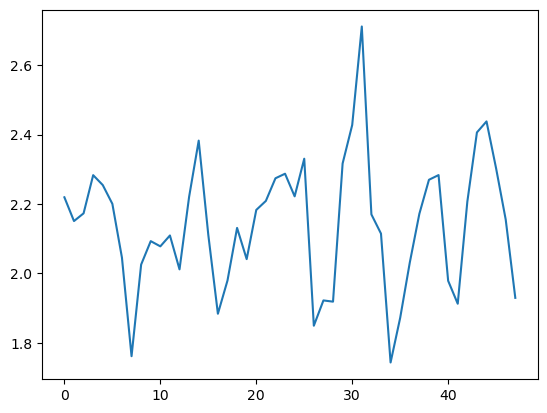

In [14]:
# special cases: scale factors

# HFC23 - no obvious trend so use period mean
pl.plot(
    df_emissions.loc[df_emissions['variable']=='Emissions|HFC|HFC23', first_valid_year['Emissions|HFC|HFC23']:'2022'].values.squeeze()
    /df_inverse.loc[df_inverse['variable']=='Emissions|HFC|HFC23', first_valid_year['Emissions|HFC|HFC23']:'2022'].values.squeeze()
)
hfc23_sf = (
    df_emissions.loc[df_emissions['variable']=='Emissions|HFC|HFC23', first_valid_year['Emissions|HFC|HFC23']:'2022'].values.squeeze()
    /df_inverse.loc[df_inverse['variable']=='Emissions|HFC|HFC23', first_valid_year['Emissions|HFC|HFC23']:'2022'].values.squeeze()
).mean()
hfc23_sf

In [15]:
df_emissions.loc[df_emissions['variable']=='Emissions|HFC|HFC23', '1750':str(int(first_valid_year['Emissions|HFC|HFC23'])-1)] = (
    hfc23_sf * df_inverse.loc[df_inverse['variable']=='Emissions|HFC|HFC23', '1750':str(int(first_valid_year['Emissions|HFC|HFC23'])-1)].values
)

np.float64(0.9193347985820227)

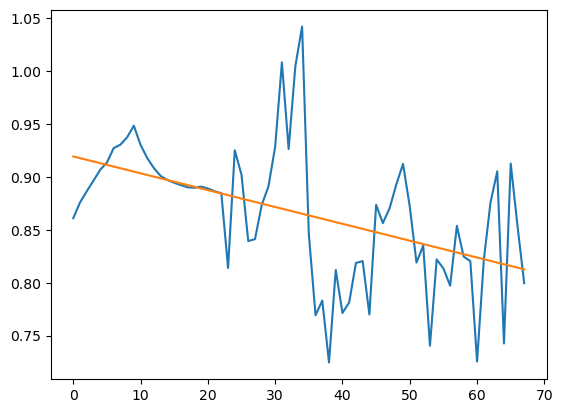

In [16]:
# CCl4 - looks like a trend so regress it
ccl4_ratio = (
    df_emissions.loc[df_emissions['variable']=='Emissions|Montreal Gases|CCl4', first_valid_year['Emissions|Montreal Gases|CCl4']:'2022'].values.squeeze()
    /df_inverse.loc[df_inverse['variable']=='Emissions|Montreal Gases|CCl4', first_valid_year['Emissions|Montreal Gases|CCl4']:'2022'].values.squeeze()
)

pl.plot(ccl4_ratio)

lreg = linregress(np.arange(len(ccl4_ratio)), ccl4_ratio)

pl.plot(np.arange(len(ccl4_ratio)), lreg.slope * np.arange(len(ccl4_ratio)) + lreg.intercept)

ccl4_sf = lreg.intercept
ccl4_sf

In [17]:
df_emissions.loc[df_emissions['variable']=='Emissions|Montreal Gases|CCl4', '1750':str(int(first_valid_year['Emissions|Montreal Gases|CCl4'])-1)] = (
    ccl4_sf * df_inverse.loc[df_inverse['variable']=='Emissions|Montreal Gases|CCl4', '1750':str(int(first_valid_year['Emissions|Montreal Gases|CCl4'])-1)].values
)

In [18]:
# join with inverse: most others
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for variable in [
        'Emissions|HFC|HFC125',
        'Emissions|HFC|HFC134a',
        'Emissions|HFC|HFC143a',
        'Emissions|HFC|HFC152a',
        'Emissions|HFC|HFC227ea',
        'Emissions|HFC|HFC236fa',
        'Emissions|HFC|HFC245fa',
        'Emissions|HFC|HFC32',
        'Emissions|HFC|HFC365mfc',
        'Emissions|HFC|HFC43-10',
        'Emissions|Montreal Gases|CFC|CFC11',
        'Emissions|Montreal Gases|CFC|CFC113',
        'Emissions|Montreal Gases|CFC|CFC114',
        'Emissions|Montreal Gases|CFC|CFC115',
        'Emissions|Montreal Gases|CFC|CFC12',
        'Emissions|Montreal Gases|CH3CCl3',
        'Emissions|Montreal Gases|Halon1211',
        'Emissions|Montreal Gases|Halon1301',
        'Emissions|Montreal Gases|Halon2402',
        'Emissions|Montreal Gases|HCFC141b',
        'Emissions|Montreal Gases|HCFC142b',
        'Emissions|Montreal Gases|HCFC22'
    ]:
        # handle duplicates
        # print(df_inverse.loc[df_inverse['variable']==variable])
        # row_select = df_inverse.loc[df_inverse['variable']==variable].iloc[0, :]
        df_emissions.loc[df_emissions['variable']==variable, '1750':str(int(first_valid_year[variable])-1)] = (
            df_inverse.loc[df_inverse['variable']==variable, '1750':str(int(first_valid_year[variable])-1)].values
        )
        #print(df_inverse.loc[df_inverse['variable']==variable, '1750':str(int(first_valid_year[variable])-1)])
        # df_emissions.loc[df_emissions['variable']==variable, '1750':str(int(first_valid_year[variable])-1)] = (
        #     row_select['1750':str(int(first_valid_year[variable])-1)].to_frame().T
        # )

In [19]:
# join about 1980
df_inverse.loc[df_inverse['variable']=='Emissions|SF6', "1750":"1979"]

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.161815,1.263418,1.371516,1.48656,1.609042,1.739499,1.878515,2.026717,2.184757,2.353289


In [20]:
# join about 1980
for variable in ['Emissions|SF6', 'Emissions|C2F6', 'Emissions|CF4']:
    df_emissions.loc[df_emissions['variable']==variable, '1750':'1979'] = (
        df_inverse.loc[df_inverse['variable']==variable, "1750":"1979"].values
    )

In [21]:
# CO2 AFOLU: Zeb wants more of a spline cut in 1750-1850; but it's such a piddly small forcing and very uncertain so linear is fine IMO
# 30 GtC cumulative is what GCB say for 1750-1850
linear_ramp_up = np.arange(0.003, 0.6, 0.006)

In [22]:
# check adds up to 30 GtC
np.cumsum(linear_ramp_up)[-1]

np.float64(30.000000000000007)

In [23]:
# and is 100 years long
len(linear_ramp_up)

100

In [24]:
df_emissions.loc[df_emissions['variable']=='Emissions|CO2|AFOLU', '1750':'1849'] = linear_ramp_up * 44.009/12.011  # put in GtCO2 units

In [25]:
# implement IGCC2024 extensions of SLCFs for 2024
# in FFI & ag., this is based on CEDS (soon to be published) for 2023, and CAMS for 2024
# for biomass burning, this is based on GFED (public until 2023, 2024 version supplied by Guido van der Werf).
# see https://github.com/ClimateIndicator/forcing-timeseries/tree/ceds2025/notebooks (to update once merged)
df_slcf = pd.read_csv('../data/input/slcf_emissions_1750-2024.csv', index_col=0)

name_map = {species: f'Emissions|{species}' for species in df_slcf.columns}
name_map['SO2'] = 'Emissions|Sulfur'
name_map['NMVOC'] = 'Emissions|VOC'

for species in df_slcf.columns:
    df_emissions.loc[df_emissions['variable']==name_map[species], '2024'] = df_slcf.loc[2024, species]

In [26]:
# include the CO2 emissions from 2024 in GCB in here too
# we assume that CEDS does not include cement carbonation (think explicitly mentioned somewhere)
# GCB: preliminary estimates are 0.8% above 2023 for 2024 (https://essd.copernicus.org/articles/17/965/2025/essd-17-965-2025.html)
df_emissions.loc[df_emissions['variable']=='Emissions|CO2|Energy and Industrial Processes', '2024'] = (
    1.008 *
    df_emissions.loc[df_emissions['variable']=='Emissions|CO2|Energy and Industrial Processes', '2023']
)
df_emissions.loc[df_emissions['variable']=='Emissions|CO2|Energy and Industrial Processes', '2015':]

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
10,36.013859,36.060509,36.659376,37.333575,37.409599,35.718601,37.819846,38.087297,38.712217,39.021915


In [27]:
# in land use, preliminary estimates are 4.2 GtCO2 (https://essd.copernicus.org/articles/17/965/2025/essd-17-965-2025.html)
# the GtC to GtCO2 conversion isn't quite right - perhaps both numbers are rounded
# in which case use the GtCO2 value since the 2 sf precision is a smaller fraction of the estimate for 4.2 versus 1.2
df_emissions.loc[df_emissions['variable']=='Emissions|CO2|AFOLU', '2024'] = 4.2
df_emissions.loc[df_emissions['variable']=='Emissions|CO2|AFOLU', '2015':]

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
24,5.535614,4.40946,4.234098,3.847515,3.789499,3.441499,3.555369,3.543616,3.627551,4.2


In [28]:
# For CH4 and N2O, we can use CAMS estimate for 2024 plus GFED from Guido
# This is prepared for the Climate Indicators 2024
df_emissions.loc[df_emissions['variable']=='Emissions|CH4', '2024'] = df_slcf.loc[2024, 'CH4']
df_emissions.loc[df_emissions['variable']=='Emissions|N2O', '2024'] = df_slcf.loc[2024, 'N2O']

In [29]:
df_emissions#.loc[df_emissions['variable']==f'Emissions|{species}', str(year)]

,model,scenario,variable,region,unit,1750,1751,1752,1753,1754,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,"Adam et al., 2024",historical,Emissions|HFC|HFC23,World,kt HFC23/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,12.873911,12.786738,15.123099,16.832850,17.311925,16.505140,15.533804,13.954472,14.051843,NaN
1,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|BC,World,Mt BC/yr,2.120093,2.095695,2.087551,2.095685,2.123610,...,7.629747,7.230268,7.292787,7.092049,7.394743,6.970417,7.339760,6.699266,7.557077,7.513804
2,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|CH4,World,Mt CH4/yr,40.669223,40.535916,40.480450,40.680802,41.035811,...,354.122762,345.692180,348.736373,351.901783,358.850123,345.322687,355.843503,354.909306,369.092729,367.545240
3,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|CO,World,Mt CO/yr,348.838265,344.229341,342.107935,343.976352,350.125174,...,891.630067,753.791984,746.266581,741.428971,816.666647,727.501488,786.430347,665.832281,896.703380,845.321751
4,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|N2O,World,Mt N2O/yr,0.908671,0.898445,0.894552,0.899437,0.919329,...,10.670047,10.559820,10.773385,10.846542,11.037534,10.902966,11.362419,10.877249,11.611055,11.500004
5,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|NH3,World,Mt NH3/yr,6.752106,6.683606,6.642037,6.703241,6.836352,...,63.891314,63.552641,63.988451,64.625449,66.287414,66.225354,68.252751,66.823590,71.567399,70.633588
6,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|NOx,World,Mt NO2/yr,19.443706,19.223945,19.226670,19.142753,19.291447,...,139.745042,136.048305,135.812328,133.308471,134.102561,122.513800,125.887804,123.285151,128.443392,130.410063
7,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|OC,World,Mt OC/yr,16.020452,15.762729,15.609871,15.759779,16.138189,...,32.017727,27.332945,29.075610,28.119274,34.028717,29.431480,36.815407,25.604698,41.091117,36.068592
8,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|Sulfur,World,Mt SO2/yr,2.350436,2.316251,2.303261,2.315421,2.365301,...,92.294374,88.378784,84.873139,82.555913,81.107588,68.356225,71.178790,70.578348,72.655510,71.178772
9,CEDS-BB4CMIP-GFED-PRIMAP,historical,Emissions|VOC,World,Mt VOC/yr,60.931603,59.999242,59.545198,59.942928,61.191229,...,213.228990,185.865550,187.062081,186.552979,205.886462,185.547869,200.706796,176.461165,219.644313,212.745055


In [30]:
# let's see what we still need to extrapolate
# Find all the species that don't have a 2024 value; these need extrapolating
last_valid_year = {}
for variable in df_emissions.variable:
    lvy = df_emissions.loc[df_emissions['variable']==variable, '1750':].squeeze(axis=0).last_valid_index()
    if lvy != '2024':  # ignore complete variables
        last_valid_year[variable] = lvy

In [31]:
last_valid_year

{'Emissions|HFC|HFC23': '2023',
 'Emissions|C3F8': '2022',
 'Emissions|C4F10': '2022',
 'Emissions|C5F12': '2022',
 'Emissions|C6F14': '2022',
 'Emissions|C7F16': '2022',
 'Emissions|C8F18': '2022',
 'Emissions|Montreal Gases|CH2Cl2': '2022',
 'Emissions|Montreal Gases|CH3Br': '2022',
 'Emissions|Montreal Gases|CH3Cl': '2022',
 'Emissions|Montreal Gases|CHCl3': '2022',
 'Emissions|NF3': '2022',
 'Emissions|SO2F2': '2022',
 'Emissions|cC4F8': '2022',
 'Emissions|C2F6': '2021',
 'Emissions|CF4': '2021',
 'Emissions|SF6': '2021'}

In [32]:
len(last_valid_year)

17

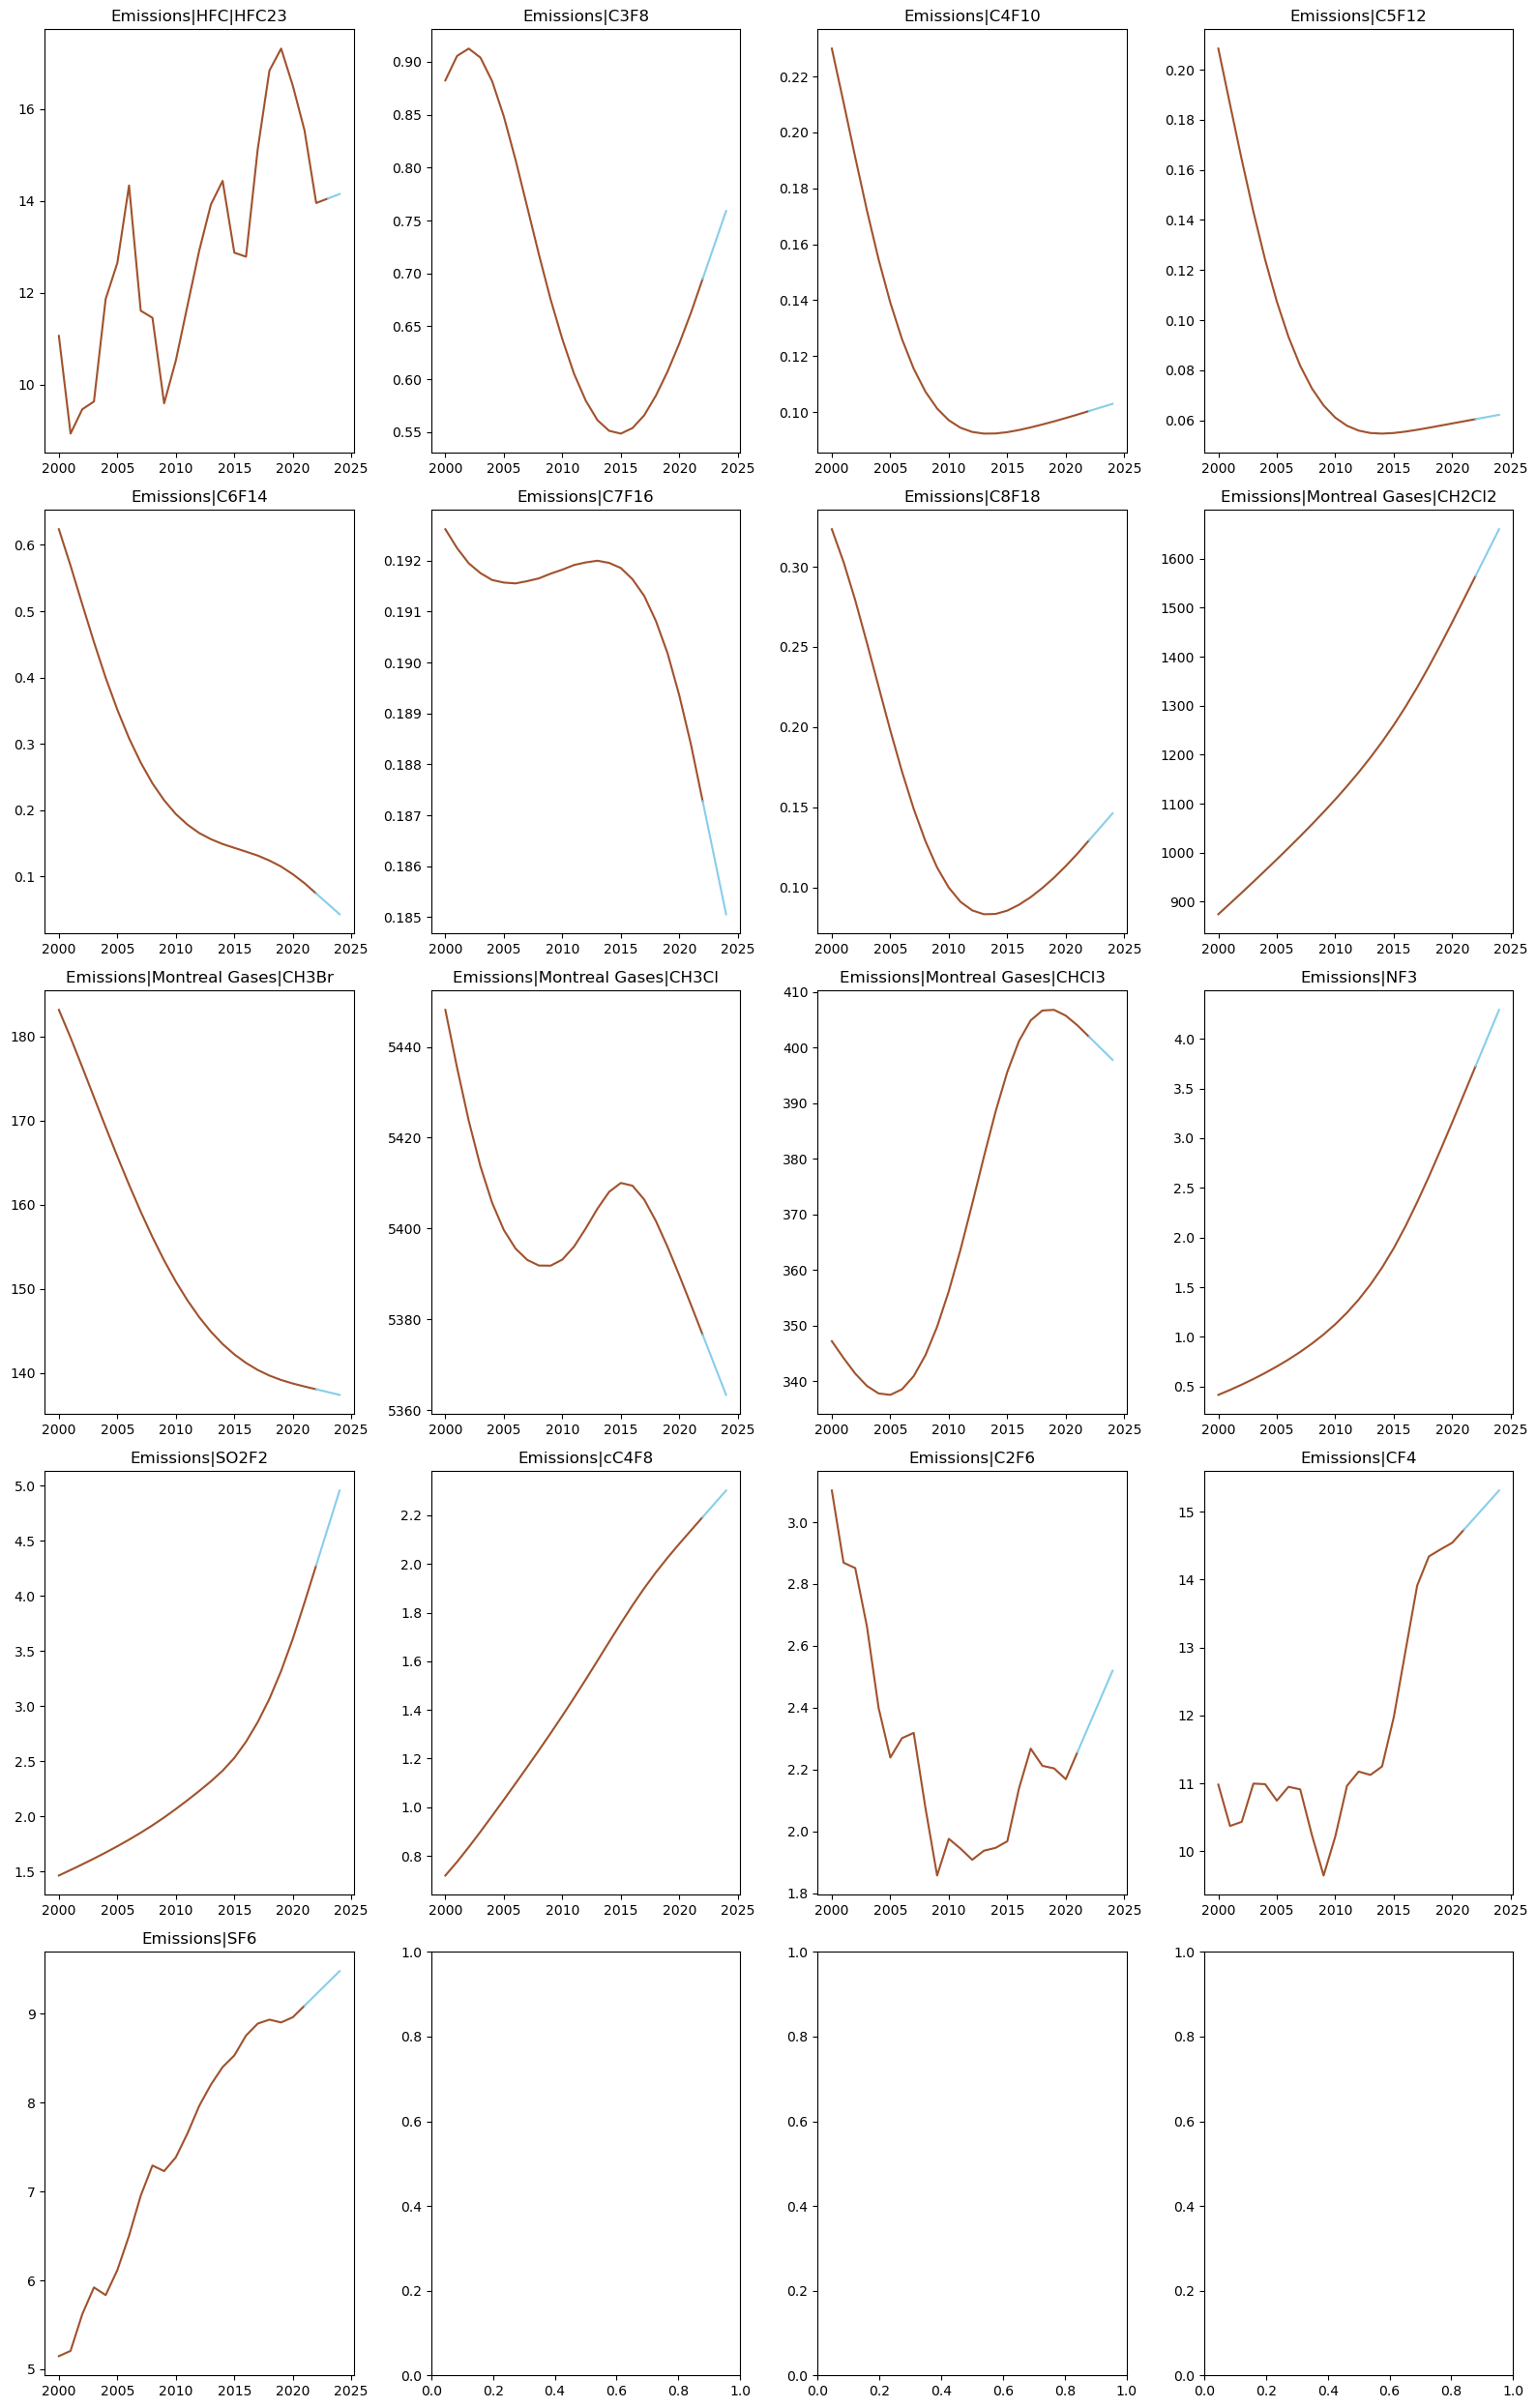

In [33]:
# let's check that the emissions look ok
# I suggest it is probably fine to extrapolate forward using the trend of the last 5 years
fig, ax = pl.subplots(5, 4, figsize = (16, 25))
ivar = 0
for variable in last_valid_year:
    ax[ivar//4, ivar%4].plot(
        np.arange(2000, int(last_valid_year[variable]) + 1), 
        df_emissions.loc[df_emissions['variable']==variable, '2000':last_valid_year[variable]].T,
        color='sienna',
        label='ScenarioMIP'
    )
    trend = (
        df_emissions.loc[df_emissions['variable']==variable, last_valid_year[variable]] -
        df_emissions.loc[df_emissions['variable']==variable, str(int(last_valid_year[variable])-1)]
    ).values[0]
    ax[ivar//4, ivar%4].plot(
        np.arange(int(last_valid_year[variable]), 2025, 1), 
        (
            df_emissions.loc[df_emissions['variable']==variable, last_valid_year[variable]].values[0] + 
            trend * (np.arange(2025-int(last_valid_year[variable])))
        ),
        color='skyblue',
        label='cubic spline'
    )
    ax[ivar//4, ivar%4].set_title(variable)
    ivar = ivar + 1
fig.tight_layout()

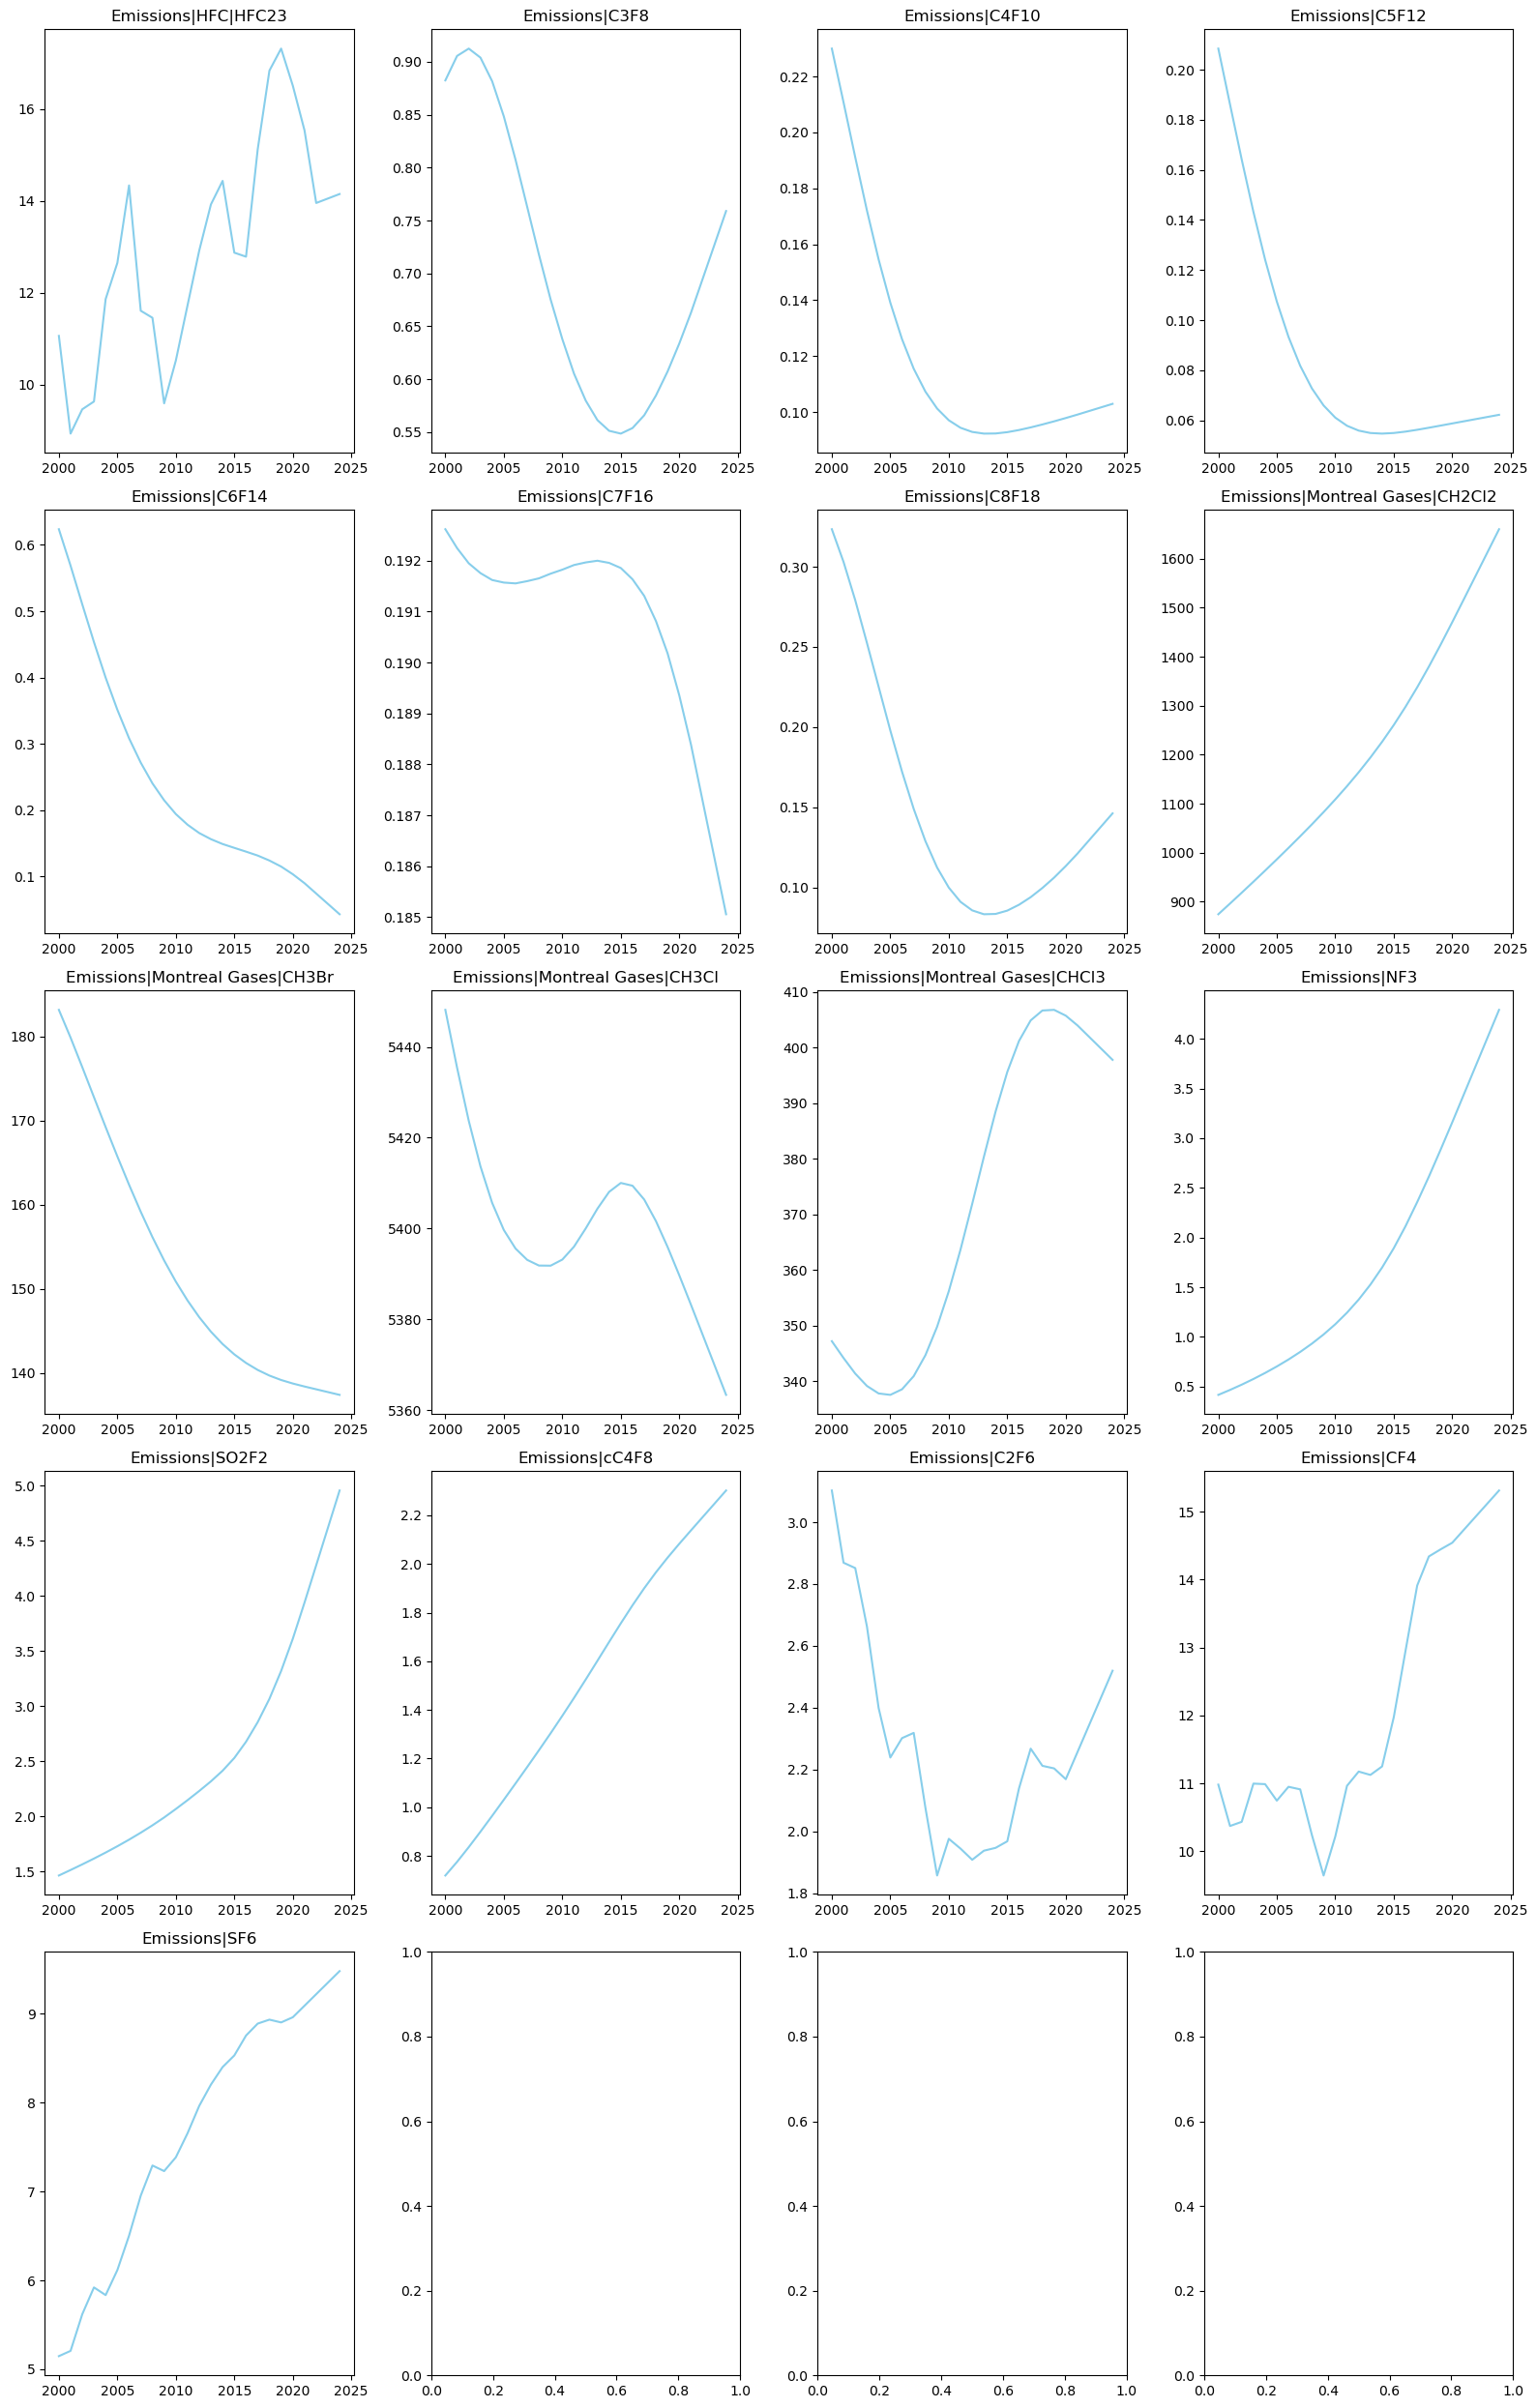

In [34]:
# let's implement
fig, ax = pl.subplots(5, 4, figsize = (16, 25))
ivar = 0
for variable in last_valid_year:
    trend = (
        df_emissions.loc[df_emissions['variable']==variable, last_valid_year[variable]] -
        df_emissions.loc[df_emissions['variable']==variable, str(int(last_valid_year[variable])-1)]
    ).values[0]
    df_emissions.loc[df_emissions['variable']==variable, str(int(last_valid_year[variable])):'2024'] = (
        df_emissions.loc[df_emissions['variable']==variable, last_valid_year[variable]].values[0] + 
        trend * (np.arange(2025-int(last_valid_year[variable])))
    )
    ax[ivar//4, ivar%4].plot(
        np.arange(2000, 2025), 
        df_emissions.loc[df_emissions['variable']==variable, '2000':'2024'].T,
        color='skyblue',
    )
    ax[ivar//4, ivar%4].set_title(variable)
    ivar = ivar + 1
fig.tight_layout()

In [35]:
# too painful to automate
scenariomip_to_fair = {
    'Emissions|HFC|HFC23': 'HFC-23',
    'Emissions|BC': 'BC',
    'Emissions|CH4': 'CH4', 
    'Emissions|CO': 'CO',
    'Emissions|N2O': 'N2O',
    'Emissions|NH3': 'NH3',
    'Emissions|NOx': 'NOx',
    'Emissions|OC': 'OC',
    'Emissions|Sulfur': 'Sulfur',
    'Emissions|VOC': 'VOC',
    'Emissions|CO2|Energy and Industrial Processes': 'CO2 FFI',
    'Emissions|C3F8': 'C3F8',
    'Emissions|C4F10': 'C4F10',
    'Emissions|C5F12': 'C5F12',
    'Emissions|C6F14': 'C6F14',
    'Emissions|C7F16': 'C7F16',
    'Emissions|C8F18': 'C8F18',
    'Emissions|Montreal Gases|CH2Cl2': 'CH2Cl2',
    'Emissions|Montreal Gases|CH3Br': 'CH3Br',
    'Emissions|Montreal Gases|CH3Cl': 'CH3Cl',
    'Emissions|Montreal Gases|CHCl3': 'CHCl3',
    'Emissions|NF3': 'NF3',
    'Emissions|SO2F2': 'SO2F2',
    'Emissions|cC4F8': 'c-C4F8',
    'Emissions|CO2|AFOLU': 'CO2 AFOLU',
    'Emissions|HFC|HFC125': 'HFC-125',
    'Emissions|HFC|HFC134a': 'HFC-134a',
    'Emissions|HFC|HFC143a': 'HFC-143a',
    'Emissions|HFC|HFC152a': 'HFC-152a',
    'Emissions|HFC|HFC227ea': 'HFC-227ea',
    'Emissions|HFC|HFC236fa': 'HFC-236fa',
    'Emissions|HFC|HFC245fa': 'HFC-245fa',
    'Emissions|HFC|HFC32': 'HFC-32',
    'Emissions|HFC|HFC365mfc': 'HFC-365mfc',
    'Emissions|HFC|HFC43-10': 'HFC-4310mee',
    'Emissions|Montreal Gases|CCl4': 'CCl4',
    'Emissions|Montreal Gases|CFC|CFC11': 'CFC-11',
    'Emissions|Montreal Gases|CFC|CFC113': 'CFC-113',
    'Emissions|Montreal Gases|CFC|CFC114': 'CFC-114',
    'Emissions|Montreal Gases|CFC|CFC115': 'CFC-115',
    'Emissions|Montreal Gases|CFC|CFC12': 'CFC-12',
    'Emissions|Montreal Gases|CH3CCl3': 'CH3CCl3',
    'Emissions|Montreal Gases|HCFC141b': 'HCFC-141b',
    'Emissions|Montreal Gases|HCFC142b': 'HCFC-142b',
    'Emissions|Montreal Gases|HCFC22': 'HCFC-22',
    'Emissions|Montreal Gases|Halon1211': 'Halon-1211',
    'Emissions|Montreal Gases|Halon1301': 'Halon-1301',
    'Emissions|Montreal Gases|Halon2402': 'Halon-2402',
    'Emissions|C2F6': 'C2F6',
    'Emissions|CF4': 'CF4',
    'Emissions|SF6': 'SF6'
}

In [36]:
# for ease, give all "model" column the same name and make the variable name consistent with fair
df_emissions['model']='reconstructed'
df_emissions['variable'] = df_emissions['variable'].replace(scenariomip_to_fair)

In [37]:
df_emissions

,model,scenario,variable,region,unit,1750,1751,1752,1753,1754,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,reconstructed,historical,HFC-23,World,kt HFC23/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,12.873911,12.786738,15.123099,16.832850,17.311925,16.505140,15.533804,13.954472,14.051843,14.149215
1,reconstructed,historical,BC,World,Mt BC/yr,2.120093,2.095695,2.087551,2.095685,2.123610,...,7.629747,7.230268,7.292787,7.092049,7.394743,6.970417,7.339760,6.699266,7.557077,7.513804
2,reconstructed,historical,CH4,World,Mt CH4/yr,40.669223,40.535916,40.480450,40.680802,41.035811,...,354.122762,345.692180,348.736373,351.901783,358.850123,345.322687,355.843503,354.909306,369.092729,367.545240
3,reconstructed,historical,CO,World,Mt CO/yr,348.838265,344.229341,342.107935,343.976352,350.125174,...,891.630067,753.791984,746.266581,741.428971,816.666647,727.501488,786.430347,665.832281,896.703380,845.321751
4,reconstructed,historical,N2O,World,Mt N2O/yr,0.908671,0.898445,0.894552,0.899437,0.919329,...,10.670047,10.559820,10.773385,10.846542,11.037534,10.902966,11.362419,10.877249,11.611055,11.500004
5,reconstructed,historical,NH3,World,Mt NH3/yr,6.752106,6.683606,6.642037,6.703241,6.836352,...,63.891314,63.552641,63.988451,64.625449,66.287414,66.225354,68.252751,66.823590,71.567399,70.633588
6,reconstructed,historical,NOx,World,Mt NO2/yr,19.443706,19.223945,19.226670,19.142753,19.291447,...,139.745042,136.048305,135.812328,133.308471,134.102561,122.513800,125.887804,123.285151,128.443392,130.410063
7,reconstructed,historical,OC,World,Mt OC/yr,16.020452,15.762729,15.609871,15.759779,16.138189,...,32.017727,27.332945,29.075610,28.119274,34.028717,29.431480,36.815407,25.604698,41.091117,36.068592
8,reconstructed,historical,Sulfur,World,Mt SO2/yr,2.350436,2.316251,2.303261,2.315421,2.365301,...,92.294374,88.378784,84.873139,82.555913,81.107588,68.356225,71.178790,70.578348,72.655510,71.178772
9,reconstructed,historical,VOC,World,Mt VOC/yr,60.931603,59.999242,59.545198,59.942928,61.191229,...,213.228990,185.865550,187.062081,186.552979,205.886462,185.547869,200.706796,176.461165,219.644313,212.745055


In [38]:
os.makedirs('../data/output', exist_ok=True)

In [39]:
# save out the first raw version
df_emissions.to_csv('../data/output/historical_emissions_1750-2024.csv', index=False)

In [40]:
# version for historical harmonizations:
# rename variable
# dump everything before 2015 (we don't harmonize before then)
# take 5 year running mean of all SLCFs (NOT SULFUR BECAUSE MOSTLY EEI) and CO2 AFOLU as the harmonization value
# extrapolate 2023 and 2024 using trend of 5-year running means
# make same model (not sure if needed, but will help)
df_historical_harmonization = df_emissions.copy()
variables_to_mean = ['BC', 'OC', 'CO', 'NH3', 'NOx', 'VOC', 'CO2 AFOLU']
for variable in variables_to_mean:
    for year in range(2015, 2023):
        df_historical_harmonization.loc[df_historical_harmonization['variable']==variable, str(year)] = (
            df_emissions.loc[df_emissions['variable']==variable, str(year-2):str(year+2)].mean(axis=1).values
        )
    lrr = (
        linregress(
            np.arange(2018, 2023),
            df_historical_harmonization.loc[df_historical_harmonization['variable']==variable, '2018':'2022']
        )
    )
    df_historical_harmonization.loc[df_historical_harmonization['variable']==variable, '2023':'2024'] = (
        lrr.slope * np.array((2023, 2024)) + lrr.intercept
    )
to_drop = [str(year) for year in range(1750, 2014)]
df_historical_harmonization.drop(columns=to_drop, inplace=True)
#df_historical_harmonization['model']='reconstructed'
#df_historical_harmonization['variable'] = df_historical_harmonization['variable'].replace(scenariomip_to_fair)
    #list(df_historical_harmonization['variable'].values)
#df_historical_harmonization.replace(to_replace='Emissions|*', value='', regex=True)
df_historical_harmonization

,model,scenario,variable,region,unit,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,reconstructed,historical,HFC-23,World,kt HFC23/yr,14.435299,12.873911,12.786738,15.123099,16.832850,17.311925,16.505140,15.533804,13.954472,14.051843,14.149215
1,reconstructed,historical,BC,World,Mt BC/yr,7.653825,7.474690,7.379735,7.327919,7.196053,7.217951,7.099247,7.192253,7.216065,7.188611,7.190044
2,reconstructed,historical,CH4,World,Mt CH4/yr,348.431441,354.122762,345.692180,348.736373,351.901783,358.850123,345.322687,355.843503,354.909306,369.092729,367.545240
3,reconstructed,historical,CO,World,Mt CO/yr,839.899652,803.629794,794.603451,789.956850,757.131134,763.658807,747.571947,778.626829,784.357850,787.095749,794.037894
4,reconstructed,historical,N2O,World,Mt N2O/yr,10.564922,10.670047,10.559820,10.773385,10.846542,11.037534,10.902966,11.362419,10.877249,11.611055,11.500004
5,reconstructed,historical,NH3,World,Mt NH3/yr,62.994372,63.241018,63.810445,64.469054,64.935862,65.875884,66.442911,67.831301,68.700536,69.602729,70.551206
6,reconstructed,historical,NOx,World,Mt NO2/yr,139.859923,138.466577,136.954814,135.803341,132.357093,130.324993,127.819557,126.846542,126.108042,123.898280,122.300624
7,reconstructed,historical,OC,World,Mt OC/yr,29.759199,29.020257,29.260951,30.114854,29.597605,31.494097,30.799915,33.394284,33.802259,34.910480,35.941429
8,reconstructed,historical,Sulfur,World,Mt SO2/yr,98.073605,92.294374,88.378784,84.873139,82.555913,81.107588,68.356225,71.178790,70.578348,72.655510,71.178772
9,reconstructed,historical,VOC,World,Mt VOC/yr,199.577847,193.943707,194.457489,195.719212,190.182988,193.151237,191.031054,197.649321,199.021039,200.859384,203.076802


In [41]:
# save out the version for historical harmonization
df_historical_harmonization.to_csv('../data/output/historical_harmonization_5yr_running_means_2014-2024.csv', index=False)

In [42]:
# # finally, make into a fair format emissions file
# # drop model and put on half-years


# this is not modified from above yet


# df_fair_calibrate = df_emissions.copy()
# variables_to_mean = ['BC', 'OC', 'CO', 'NH3', 'NOx', 'VOC', 'CO2|AFOLU']
# for variable in variables_to_mean:
#     for year in range(2015, 2023):
#         df_historical_harmonization.loc[df_historical_harmonization['variable']==f'Emissions|{variable}', str(year)] = (
#             df_emissions.loc[df_emissions['variable']==f'Emissions|{variable}', str(year-2):str(year+2)].mean(axis=1).values
#         )
#     lrr = (
#         linregress(
#             np.arange(2018, 2023),
#             df_historical_harmonization.loc[df_historical_harmonization['variable']==f'Emissions|{variable}', '2018':'2022']
#         )
#     )
#     df_historical_harmonization.loc[df_historical_harmonization['variable']==f'Emissions|{variable}', '2023':'2024'] = (
#         lrr.slope * np.array((2023, 2024)) + lrr.intercept
#     )
# to_drop = [str(year) for year in range(1750, 2014)]
# df_historical_harmonization.drop(columns=to_drop, inplace=True)
# df_historical_harmonization['model']='reconstructed'
# df_historical_harmonization['variable'] = df_historical_harmonization['variable'].replace(scenariomip_to_fair)
#     #list(df_historical_harmonization['variable'].values)
# #df_historical_harmonization.replace(to_replace='Emissions|*', value='', regex=True)
# df_historical_harmonization

In [43]:
# make into a fair-format emissions input file
# rename variable
# drop model
# put on half years